In [25]:
#увеличим дефолтный размер графиков
from pylab import rcParams

def big_pic():
    rcParams['figure.figsize'] = 22,12

def small_pic():
    rcParams['figure.figsize'] = 11,6

small_pic()

# импортируем нужные библиотеки
import pandas as pd
import matplotlib.pyplot as plt 
from datetime import datetime, date, time
import seaborn as sns

import numpy as np

# Запросы для извлечения данных

# Чтение и предобработка

### Аварии (лог)

In [10]:
accidents = pd.read_csv('cep_accident_guts.csv')
#уберем незаполненные данные
accidents = accidents.dropna()
accidents.reset_index()

#имя города меняем для соответсвия между датасетами
def city_name(db_uid):
    if db_uid == 'ERTEL-IZ':
        return 'spb'
    elif db_uid == 'ERTEL-NABCHEL':
        return 'chelny'
    elif db_uid == 'ERTEL-KAZAN':
        return 'kzn'
    elif db_uid == 'ERTEL-NIZHNOVG':
        return 'nn'
    elif db_uid == 'ERTEL-ORENB':
        return 'oren'    
    elif db_uid == 'ERTEL-TUMEN':
        return 'tmn'  
    elif db_uid == 'ERTEL-VOLG':
        return 'volgograd'  
    elif db_uid == 'ERTEL-YOSHK':
        return 'yola'  
    elif db_uid == 'ERTEL-NOVOSIB':
        return 'novosib'  
    else:
        return db_uid[6:].lower()

accidents['city'] = accidents['db_uid'].map(city_name)
#accidents['duration'] = accidents['end_time']-accidents['start_time']
#accidents.head()

def to_date(time):
        return datetime.strptime(time, "%Y-%m-%d %H:%M:%S")

accidents['end_time'] = accidents['end_time'].map(to_date)
accidents['start_time'] = accidents['start_time'].map(to_date)
accidents['duration'] = accidents['end_time'] - accidents['start_time']
accidents['ip']=accidents['net_address']

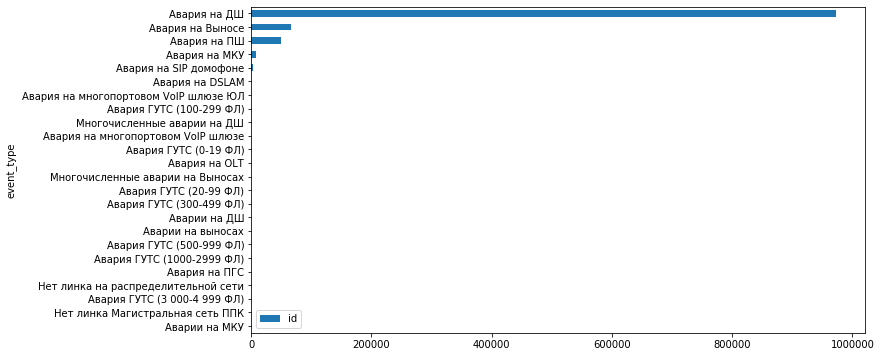

In [13]:
#исследуем выборку частоту аварий в разрезе типов событий. 
#выбран такой тип диаграммы, т.к. можно увидеть полный список типов событий, оценить их количество, соотнести с ожидаемым
#соотношеним
small_pic()
event_type_acc = accidents[['id','event_type']].groupby(['event_type']).count()
event_type_acc.sort_values('id', ascending = True).plot.barh()

In [14]:
#основной объем аварий: типы ДШ, ПШ, выносы, МКУ, sip-домофоны (выносы и домофоны исключим из анализа, т.к. события нерелевантны
#основной задаче)
events_to_analyse = ['Авария на ДШ','Авария на ПШ','Авария на МКУ']
accidents = accidents[accidents['event_type'].isin(events_to_analyse)].dropna()

#event_type_acc = accidents[['id','event_type']].groupby(['event_type']).count()

In [38]:
accidents.head()

,id,start_time,end_time,event_type,db_uid,arm_uhs,net_address,device_class,city,duration,ip
3,c21bf536-2ad7-4cfe-a94b-331d10047ccb,2019-04-16 19:40:03,2019-04-16 19:48:58,Авария на ДШ,ERTEL-IZHEVSK,УГС 02,10.248.58.214,DES-1228/ME,izhevsk,00:08:55,10.248.58.214
4,2ad1e861-2434-4b0a-846e-5e512577e4e0,2019-04-16 19:40:03,2019-04-16 19:48:58,Авария на ПШ,ERTEL-IZHEVSK,УГС 02,10.248.58.218,DES-3028,izhevsk,00:08:55,10.248.58.218
5,aa984f06-ce3b-49d4-b0d5-d9b8d4e69c84,2019-04-16 19:40:03,2019-04-16 19:48:58,Авария на ДШ,ERTEL-IZHEVSK,УГС 02,10.248.58.211,DES-3028,izhevsk,00:08:55,10.248.58.211
6,a31db4f9-774a-41a8-98a4-80aa9fd1ec39,2019-06-06 10:59:20,2019-06-06 17:30:53,Авария на ДШ,ERTEL-TULA,МГС 03,10.229.52.100,DES-1228/ME,tula,06:31:33,10.229.52.100
7,377143fd-26d4-4451-99f2-3d2272795150,2019-06-06 16:05:48,2019-06-06 17:30:30,Авария на ДШ,ERTEL-NIZHNOVG,МГС 01,10.240.231.51,DES-1228/ME,nn,01:24:42,10.240.231.51


### Справочник коммутаторов

In [16]:
switches = pd.read_csv('switches.csv')
switches.head()

,city,ip,unified_house_id,ups_count,different_house_dependants_count,total_dependants_count,is_in_ring
0,tomsk,10.226.23.97,247348,1,0,0,1
1,tomsk,10.226.23.129,246847,1,0,0,1
2,tomsk,10.226.23.180,246847,1,0,0,1
3,tomsk,10.226.20.209,245504,0,0,0,0
4,tomsk,10.226.17.97,245002,1,0,0,0


# Анализ

### Удельная аварийность на коммутатор в разрезе городов

In [17]:
#удельная аварийность на 1 коммутатор за период
sw_pivot = pd.pivot_table(switches, index='city',values='ups_count', aggfunc='count',margins=True)
acc_pivot = pd.pivot_table(accidents[['city','id']], index='city',aggfunc='count',margins=True)

acc_by_sw = sw_pivot.merge(acc_pivot, how = 'left', on = 'city').dropna()
acc_by_sw['acc_by_sw']=acc_by_sw['id']/acc_by_sw['ups_count'] #новая метрика

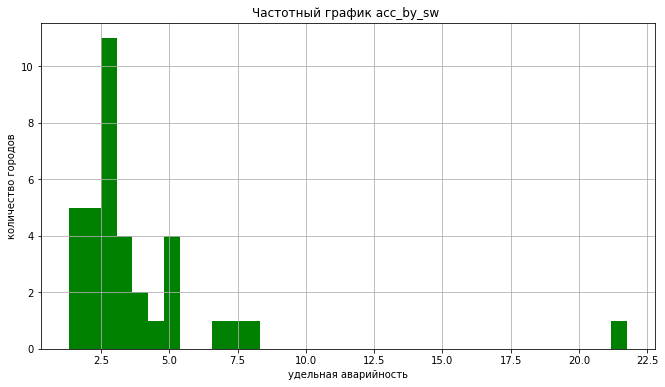

In [18]:
#смотрим распределние 
#выбран график, на котором хорошо видно, что распределение похоже на нормальное. Некоторые гордода явно выделяются,
#можно предположить, что это вызвано крупными авариями на сети, которые затронули сотни коммутаторов (обрыв оптики, отключение ЭЭ)
plt.hist(acc_by_sw['acc_by_sw'], 35, facecolor='g')
plt.xlabel('удельная аварийность')
plt.ylabel('количество городов')
plt.title('Частотный график acc_by_sw ')
plt.grid(True)
plt.show()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000221086547B8>,
      dtype=object)

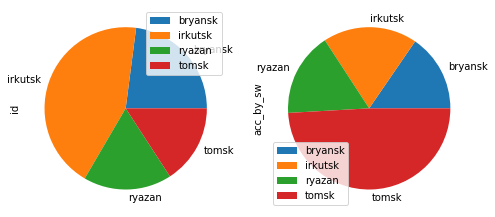

In [34]:
#ищем города, где аварийность наиболее высокая (потенциальные выбросы). Вырбран такой тип даигарммы для одновременного
#считывания списка городов и оценки соотношения количества аварий. Видим, что выдеялется Иркутск.
acc_by_sw_worst_cities=acc_by_sw[acc_by_sw['acc_by_sw']>6]
acc_by_sw_worst_cities.sort_values('acc_by_sw', ascending=False)
acc_by_sw_worst_cities[['id','acc_by_sw']].plot(kind='pie', subplots=True, figsize=(8, 8))
#df.plot(kind='pie', subplots=True, figsize=(8, 8))


In [28]:
#мерджим к списку коммутаторов информацию об авариях
acc_duration_by_device = pd.pivot_table(accidents, index=['city','ip'],values='duration', aggfunc='sum')
acc_count_by_device = pd.pivot_table(accidents, index=['city','ip'], values='id', aggfunc='count')

acc_by_device = switches.merge(acc_duration_by_device, how = 'left', on = 'ip').merge(acc_count_by_device, how = 'left', on = 'ip').fillna(0)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Passing integers to fillna is deprecated, will raise a TypeError in a future version.  To retain the old behavior, pass pd.Timedelta(seconds=n) instead.
  """


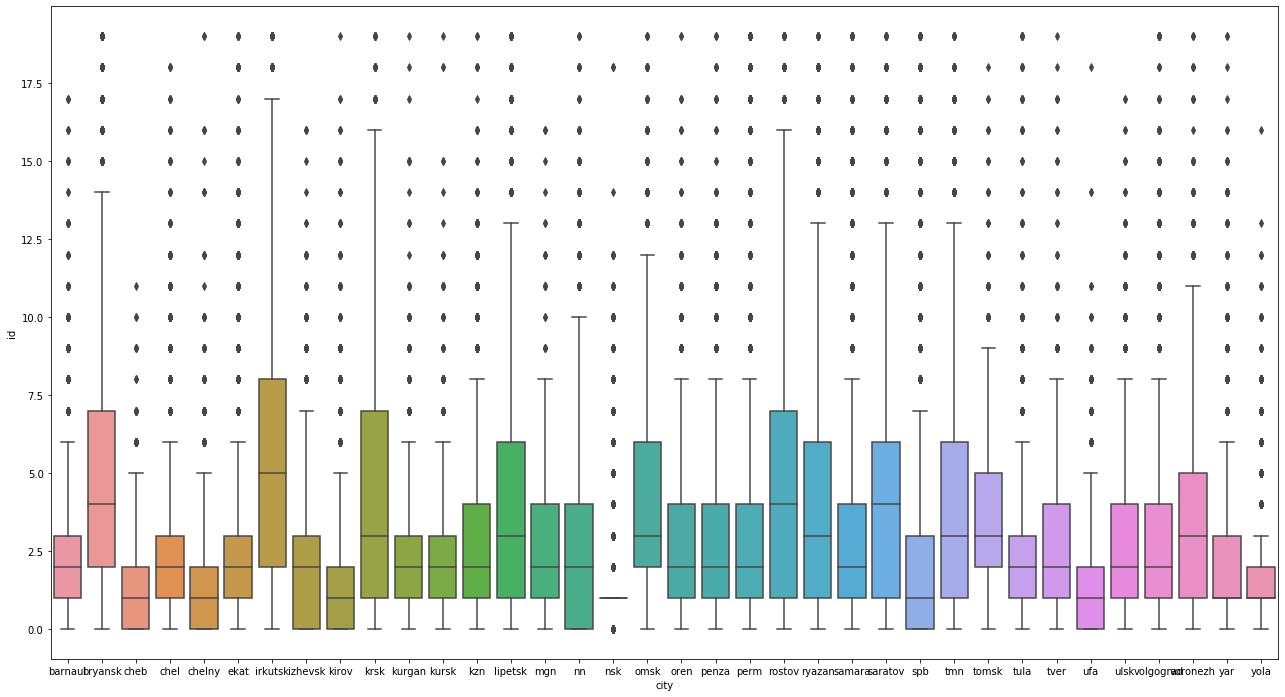

In [32]:
"""""
проводим оценку аварийности на 1 коммутатор за период. График выбран с целью проверки гипотезы о крупных авариях
судя по графику, повышенная аварийность в Томске, Рязани - следствие крупной аварии(боксплот слабо олтичается от многих других) 
В Иркутске, Брянске  другая ситуация - межквартильный интервал заменто выше, т.е. не только выбросы влияют на аварийность.
"""
big_pic()
sns.boxplot(x=acc_by_device['city'].sort_values(),y=acc_by_device[acc_by_device['id']<20]['id'])

### Детальный анализ внутри города

### Брянск

In [68]:
acc_by_device_bryansk = acc_by_device[acc_by_device['city']=='bryansk'].reset_index()

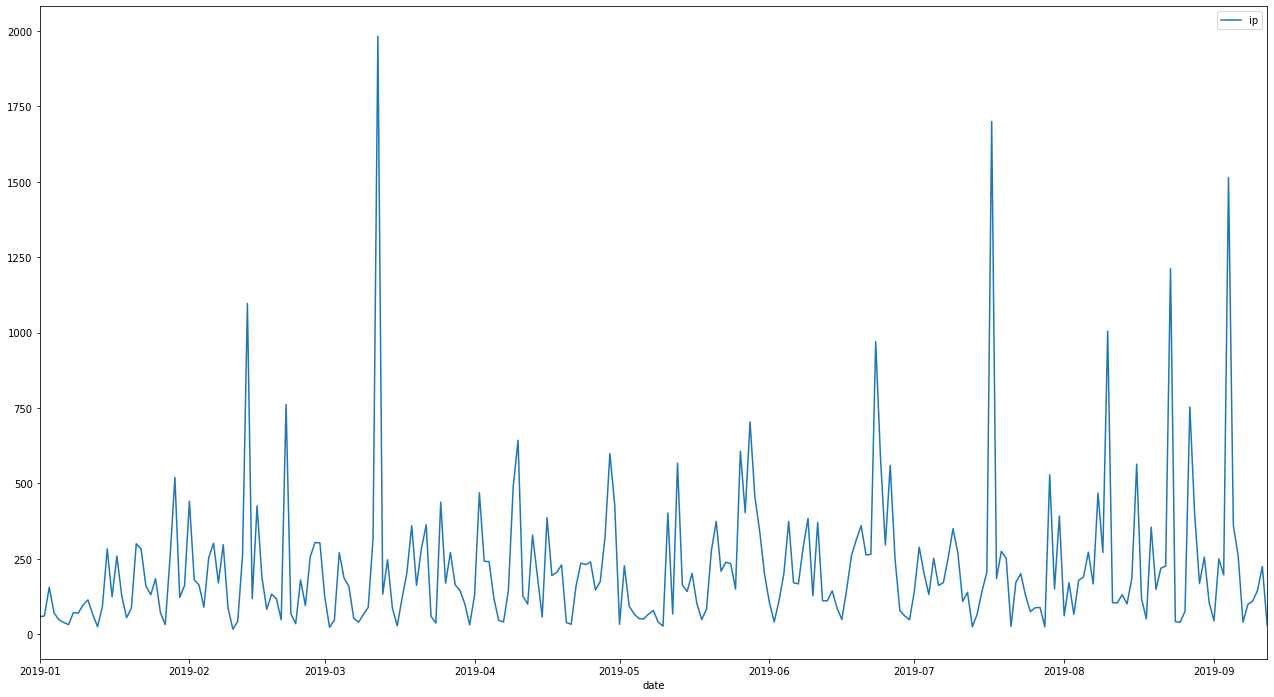

In [95]:
def extract_date(date_time):
    return datetime.date(date_time)

acc_br = accidents[accidents['city']=='bryansk'][['start_time', 'duration','ip']].sort_values('start_time', ascending=True)
#acc_br['cnt'] = int(1)
acc_br['date'] = acc_br['start_time'].map(extract_date)
acc_br=pd.pivot_table(acc_br, index='date', values='ip', aggfunc='count')
acc_br.plot()
#для конткретного города выбран тип диаграммы, показывающий динамику аварий, видны многократные всплекски, присутсвует 
#сезонность недельная. А также как минимум 4 крупные аварии.